# Project: Personalized Real Estate Agent

The objective of this notebook is to develop a property listing application in order to create a personalized experience for buyers. This seeks to make the property search process more engaging and adapted to individuals' preferences.

In [ ]:
# pip install -r requirements.txt

In [ ]:
!pip install openai==0.28
!pip install langchain_experimental
!pip install diffusers
!pip install chromadb
!pip install langchain

In [ ]:
!pip install open_clip_torch

In [3]:
# importing libraries
import os
import PIL
import torch
import pandas as pd
from typing import List
from langchain.llms import OpenAI
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from fastapi.encoders import jsonable_encoder
from diffusers import AutoPipelineForText2Image
from langchain.output_parsers import PydanticOutputParser
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from langchain_core.pydantic_v1 import BaseModel, Field, NonNegativeInt

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
# Environment variables
OPENAI_API_KEY = 'YOUR_API_KEY'
MODEL_NAME = 'gpt-3.5-turbo'
# MODEL_NAME = 'gpt-4.0-turbo'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGES_DIR = 'images'

## Synthetic Data Generation

Generating 20 diverse and realistic property listings containing descriptions about the property with an Large Language Model (LLM). 

### Text Generation

In [5]:
# load the model
llm = OpenAI(model_name=MODEL_NAME, temperature=0, api_key=OPENAI_API_KEY)

INSTRUCTION = "Generate twenty realistic real estate listings from diverse neighborhoods."
SAMPLE_LISTING = \
"""
Here's a sample listing:

Neighborhood: Natal, Brazil
Price (R$): 500,000
Bedrooms: 3
Bathrooms: 2
House Size (sqft): 2,000
Description: Welcome to your beachfront oasis in Natal, Brazil! This charming house features 3 bedrooms, 2 bathrooms, and breathtaking views of the Atlantic Ocean. With a spacious living area, modern kitchen, and private balcony off the master suite, it's the perfect blend of comfort and coastal living. Step outside to enjoy the sandy beach just steps away, or relax on the expansive terrace while soaking in the sun and sea breeze. This is beachfront living at its finest.
"""

/home/student/.local/lib/python3.10/site-packages/langchain_community/llms/openai.py:249: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
/home/student/.local/lib/python3.10/site-packages/langchain_community/llms/openai.py:1070: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(


In [14]:
class RealEstateListing(BaseModel):
    """
    A real estate listing.
    
    Attributes:
    - neighborhood: str
    - price: NonNegativeInt
    - bedrooms: NonNegativeInt
    - bathrooms: NonNegativeInt
    - house_size: NonNegativeInt
    - description: str
    - neighborhood_description: str
    """
    neighborhood: str = Field(description="The neighborhood where the property is located")
    price: NonNegativeInt = Field(description="The price of the property in the local currency")
    bedrooms: NonNegativeInt = Field(description="The number of bedrooms in the property")
    bathrooms: NonNegativeInt = Field(description="The number of bathrooms in the property")
    house_size: NonNegativeInt = Field(description="The size of the house in square feet")
    description: str = Field(description="A description of the property")
    neighborhood_description: str = Field(description="Description of the neighborhood.")  

class ListingCollection(BaseModel):
    """
    A collection of real estate listings.
    
    Attributes:
    - listings: List[RealEstateListing]
    """
    listings: List[RealEstateListing] = Field(description="A list of real estate listings")

In [15]:
# generate parsed output
parser = PydanticOutputParser(pydantic_object=ListingCollection)

In [16]:
# printing the prompt
prompt = PromptTemplate(
    template="{instruction}\n{sample}\n{format_instructions}\n",
    input_variables=["instruction", "sample"],
    partial_variables={"format_instructions": parser.get_format_instructions},
)

query = prompt.format(
    instruction=INSTRUCTION,
    sample=SAMPLE_LISTING,
)
print(query)

Generate twenty realistic real estate listings from diverse neighborhoods.

Here's a sample listing:

Neighborhood: Natal, Brazil
Price (R$): 500,000
Bedrooms: 3
Bathrooms: 2
House Size (sqft): 2,000
Description: Welcome to your beachfront oasis in Natal, Brazil! This charming house features 3 bedrooms, 2 bathrooms, and breathtaking views of the Atlantic Ocean. With a spacious living area, modern kitchen, and private balcony off the master suite, it's the perfect blend of comfort and coastal living. Step outside to enjoy the sandy beach just steps away, or relax on the expansive terrace while soaking in the sun and sea breeze. This is beachfront living at its finest.

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted in

In [17]:
# get the response
response = llm(query)

In [18]:
# create a dataframe from the response
result = parser.parse(response)
df = pd.DataFrame(jsonable_encoder(result.listings))
df.head()

,neighborhood,price,bedrooms,bathrooms,house_size,description,neighborhood_description
0,"Brooklyn, New York",1000000,4,2,1800,"Beautiful brownstone in the heart of Brooklyn,...","Brooklyn is known for its vibrant culture, div..."
1,"Santa Monica, California",1500000,3,3,2200,Modern beachfront condo in Santa Monica with 3...,Santa Monica is a beachfront city known for it...
2,"Dubai Marina, UAE",2000000,2,2,1500,Luxurious apartment in Dubai Marina with 2 bed...,Dubai Marina is a waterfront community known f...
3,"Tokyo, Japan",1800000,5,4,2500,"Spacious family home in Tokyo with 5 bedrooms,...",Tokyo is a bustling metropolis known for its b...
4,"Cape Town, South Africa",1200000,3,2,2000,"Charming villa in Cape Town with 3 bedrooms, 2...",Cape Town is a coastal city known for its natu...


In [19]:
# save the dataframe to a csv file
df.to_csv('real_estate_listings.csv', index_label = 'id')

### Image Generation

In [12]:
# load the pipeline
pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", 
    torch_dtype=torch.float16, 
    variant="fp16"
).to(DEVICE)

model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
prompt = "A photo for real estate listing with the following property and neighborhood description:\n{}\n\n{}"
rand_gen = torch.manual_seed(9723947)

images = []
for i, row in df.iterrows():
    custom_prompt = prompt.format(row['description'], row['neighborhood_description'])
    image = pipeline(
        prompt=custom_prompt, 
        num_inference_steps=3, # For this model you can use 1, but for normal Stable Diffusion you should use 25 or 50
        guidance_scale=1.0, # For this model 1 is fine, for normal Stable Diffusion you should use 6 or 7, or up to 10 or so
        negative_prompt=[], 
        generator=rand_gen
    ).images[0]
    images.append(image)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Description: Charming villa in Cape Town with 3 bedrooms, 2 bathrooms, and a private pool. Surrounded by lush gardens and stunning mountain views.
Neighborhood Description: Cape Town is a coastal city known for its natural beauty, diverse culture, and vibrant arts scene.


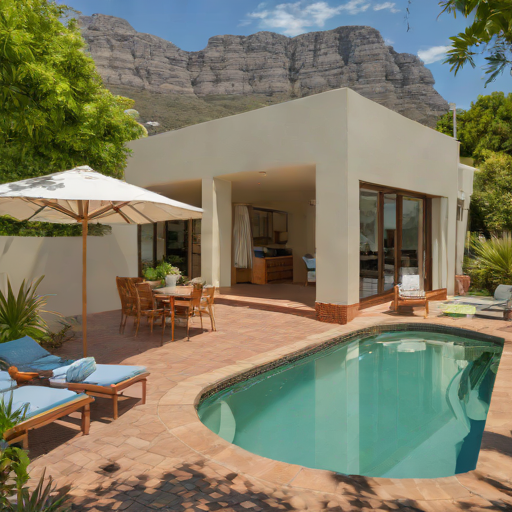

In [21]:
# print the image
idx = 4
print('Description:', df.iloc[idx]['description'])
print('Neighborhood Description:', df.iloc[idx]['neighborhood_description'])
images[idx] 

Description: Stylish penthouse in Barcelona with 2 bedrooms, 2 bathrooms, and a large terrace with city views. Close to shops and restaurants.
Neighborhood Description: Barcelona is a cosmopolitan city known for its art and architecture, lively street life, and beautiful beaches.


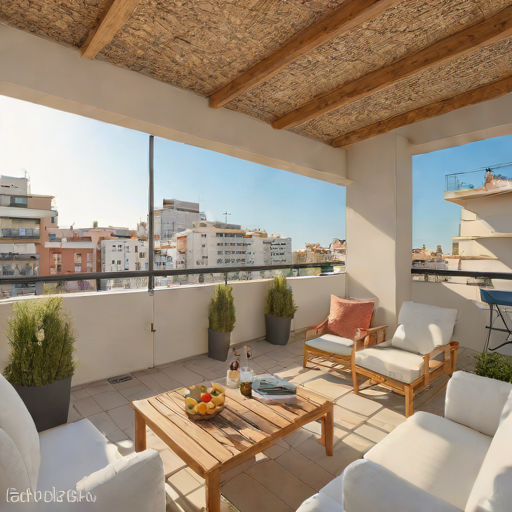

In [22]:
# print the image
idx = 7
print('Description:', df.iloc[idx]['description'])
print('Neighborhood Description:', df.iloc[idx]['neighborhood_description'])
images[idx] 

In [23]:
# create image directory
if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)

# save the images
for i, image in enumerate(images):
    filename = os.path.join(IMAGES_DIR, str(i) + ".png")
    image.save(filename)

## Multimodal Semantic Search

Creating a Vector Database and Storing Listings - The project must demonstrate the creation of a vector database and successfully storing real estate listing embeddings within it. The database should effectively store and organize the embeddings generated from the LLM-created listings.

In [24]:
# load the dataframe
df = pd.read_csv('real_estate_listings.csv')

# create empty lists to store the texts, images, and image paths
texts = []
images = []
image_paths = []

# get the ids
ids = [{'id':i} for i in range(len(df.index))]

# create text template
text_template = \
    """
    Description: {}
    Neighborhood Description: {}
    Price: {}
    Bedrooms: {}
    Bathrooms: {}
    House Size (sqft): {}
    """

# iterate over the dataframe 
for i, row in df.iterrows():
    image_file = os.path.join(IMAGES_DIR, str(i) + ".png")
    images.append(PIL.Image.open(image_file))
    image_paths.append(image_file)
    texts.append(text_template.format(row['description'],
                               row['neighborhood_description'],
                               row['price'],
                               row['bedrooms'],
                               row['bathrooms'],
                               row['house_size']))

In [27]:
# mapping both modalities to the same vector space using OpenCLIP
# so we can compare them semantically

# create vector store
db = Chroma(
    collection_name="listings", embedding_function=OpenCLIPEmbeddings()
)

# add text information
db.add_texts(texts=texts, metadatas = ids)

# add image information
db.add_images(uris=image_paths, metadatas = ids)

open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

['45e5b57c-d8fc-11ee-b911-7274cc8d179e',
 '45e5b66c-d8fc-11ee-b911-7274cc8d179e',
 '45e5b6b2-d8fc-11ee-b911-7274cc8d179e',
 '45e5b6ee-d8fc-11ee-b911-7274cc8d179e',
 '45e5b72a-d8fc-11ee-b911-7274cc8d179e',
 '45e5b766-d8fc-11ee-b911-7274cc8d179e',
 '45e5b7ac-d8fc-11ee-b911-7274cc8d179e',
 '45e5b7de-d8fc-11ee-b911-7274cc8d179e',
 '45e5b81a-d8fc-11ee-b911-7274cc8d179e',
 '45e5b856-d8fc-11ee-b911-7274cc8d179e']

In [28]:
res = db.similarity_search(
    query="",
    k=40
)

Semantic Search of Listings Based on Buyer Preferences - The application must include a functionality where listings are semantically searched based on given buyer preferences. The search should return listings that closely match the input preferences.

In [29]:
QUESTIONS = [                
    "What size house are you looking for?",
    "What are the top 3 priorities for you in selecting this property?",
    "What amenities are essential for you?",
    "What transportation options do you prefer?",
    "What level of urbanization are you seeking in your neighborhood?",
    ]


In [30]:
def get_similar_listings(preferences: List[str], top_k: int=5) -> list[int]:
    """
    Returns the ids of the top k listing 
    
    Args:
    - preferences: List of user preferences
    - top_k: Number of similar listings to return
    
    Returns:
    - List of ids of the top k similar listings
    """
    
    top_listings = []
    combined_pref = '\n'.join(preferences)
    
    result = db.similarity_search(combined_pref, k=top_k*2)
    for res in result:
        # skip if it's image r text counterpart is already considered
        # in the ranking
        if res.metadata['id'] in top_listings:
            continue
        top_listings.append(res.metadata['id'])
        
        # already gotten top listings
        if len(top_listings) == top_k:
            break
    return top_listings

## Augmented Response Generation

Logic for Searching and Augmenting Listing Descriptions - The project must demonstrate a logical flow where buyer preferences are used to search and then augment the description of real estate listings. The augmentation should personalize the listing without changing factual information.

In [31]:
INSTRUCTION = \
    """
    Create a short statement for each listing to entice the buyer given their preferences. Try to paraphrase and highlight what the buyer wants.
    """

In [32]:
class CustomizedSummary(BaseModel):
    id: int = Field(description="The id of the listing")
    summary: str = Field(description="Generated customized summary for the listing")

class CustomizedSummaryCollection(BaseModel):
    summaries: List[CustomizedSummary] = Field(description="A list of customized summaries")

# generate parsed output
parser = PydanticOutputParser(pydantic_object=CustomizedSummaryCollection)
prompt = PromptTemplate(
    template="{instruction}\nBuyer Preferences:\n{buyer_preferences}\nListings:\n{listings}\n\n{format_instructions}",
    input_variables=["instruction", "buyer_preferences", "listings"],
    partial_variables={"format_instructions": parser.get_format_instructions},
)

In [33]:
cached_summaries = {}

def generate_customized_summaries(buyer_preferences: List[str], top_k: int=5) -> list:
    """
    Generates customized summaries for the top k listings based on the buyer preferences
    
    Args:
    - buyer_preferences: List of user preferences
    - top_k: Number of similar listings to return
    
    Returns:
    - list of personalized description of the listings based in user preference
    """
    
    # get the top k similar listings
    top_listings = get_similar_listings(buyer_preferences, top_k)
    
    # create a list of listings
    listings = []
    for i in top_listings:
        listings.append(''.join(['ID:' + str(i), texts[i]]))
    
    # format the prompt
    query = prompt.format(
        instruction=INSTRUCTION,
        buyer_preferences='\n'.join(buyer_preferences),
        listings='\n'.join(listings)
    )

    # get the response
    response = []
    for summary in parser.parse(llm(query)).summaries:
        response.append((summary.id,summary.summary))
        cached_summaries[summary.id] = summary.summary
    return response

In [34]:
ANSWERS = [
        "A cozy living room.",
        "Huge windows, Furnished with a nice grey sofa for stylish comfort with some lamp shade",
        "",
        "",
        ""
]

In [35]:
ans = generate_customized_summaries(ANSWERS)
print(ans)

[(9, 'Modern apartment in Mumbai with 3 bedrooms, 2 bathrooms, and a balcony with city views. Close to shopping malls and entertainment. Perfect for a cozy living room with huge windows and furnished with a nice grey sofa for stylish comfort with some lamp shade.'), (7, 'Stylish penthouse in Barcelona with 2 bedrooms, 2 bathrooms, and a large terrace with city views. Close to shops and restaurants. Ideal for a cozy living room with huge windows, furnished with a nice grey sofa for stylish comfort with some lamp shade.'), (2, 'Luxurious apartment in Dubai Marina with 2 bedrooms, 2 bathrooms, and panoramic views of the city skyline. Close to shopping and dining. A perfect fit for a cozy living room with huge windows, furnished with a nice grey sofa for stylish comfort with some lamp shade.'), (1, 'Modern beachfront condo in Santa Monica with 3 bedrooms, 3 bathrooms, and stunning ocean views. Amenities include a pool and fitness center. Great for a cozy living room with huge windows, furn

Use of LLM for Generating Personalized Descriptions - The submission must utilize an LLM to generate personalized descriptions for the real estate listings based on buyer preferences. The descriptions should be unique, appealing, and tailored to the preferences provided.

In [36]:
ANSWERS = [
    "I prefer a cozy living room.",
    "My priorities include large windows and stylish comfort, furnished with a nice grey sofa and some lamp shades.",
    "I don't have specific amenities in mind.",
    "I'm open to any transportation options.",
    "I have no preference regarding the level of urbanization in my neighborhood."
    ]


In [37]:
ans = generate_customized_summaries(ANSWERS)
print(ans)

[(9, 'Modern apartment in Mumbai with 3 bedrooms, 2 bathrooms, and a balcony with city views. Close to shopping malls and entertainment.'), (2, 'Luxurious apartment in Dubai Marina with 2 bedrooms, 2 bathrooms, and panoramic views of the city skyline. Close to shopping and dining.'), (0, 'Beautiful brownstone in the heart of Brooklyn, featuring 4 bedrooms, 2 bathrooms, and a spacious backyard. Close to trendy restaurants and shops.'), (3, 'Spacious family home in Tokyo with 5 bedrooms, 4 bathrooms, and a traditional Japanese garden. Close to schools and parks.'), (6, 'Contemporary waterfront home in Sydney with 3 bedrooms, 2 bathrooms, and a private dock. Perfect for boating enthusiasts.')]


As we can see, the descriptions were customized and added to the original description without changing the factual information.